In [1]:
# Imports
import numpy as np
!pip install gemmi
import gemmi
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os, imageio

from skimage.transform import resize

from IPython.display import clear_output

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(0)

In [2]:
# Getting test T20S map
if not (os.path.exists('emd_6287.map.gz') or os.path.exists('emd_6287.map')):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    !gunzip 'emd_6287.map.gz'
map_path = 'emd_6287.map'

In [3]:
# https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
test_map = gemmi.read_ccp4_map(map_path)
test_map.setup()  # optional
test_numpy = np.array(test_map.grid, copy=False)

In [4]:
test_numpy = (test_numpy - np.amin(test_numpy)) / (np.amax(test_numpy) - np.amin(test_numpy))

In [5]:
print(test_numpy.shape)
print(np.unique(test_numpy))

(300, 300, 300)
[0.0000000e+00 1.3770819e-05 1.4532986e-03 ... 9.9629760e-01 9.9999148e-01
 1.0000000e+00]


In [6]:
test_slice = test_numpy[:, :, test_numpy.shape[2] // 2]
test_slice = np.expand_dims(test_slice, axis=-1)

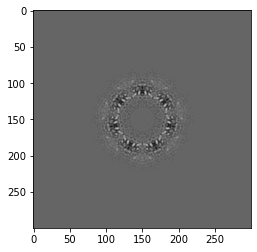

In [7]:
plt.imshow(test_slice, cmap='gray', vmin=0, vmax=1)

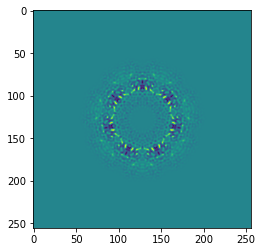

In [8]:
c = [test_slice.shape[0]//2, test_slice.shape[1]//2]
r = 256 // 2
img = test_slice[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [[x_test, img]]
train_data = [[x_test[::2,::2], img[::2,::2]]]

In [9]:
print(train_data[0][0].shape)

(128, 128, 2)


In [10]:
# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

'''
# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)
'''
# PyTorch network definition
class fourier_feature_network(nn.Module):
    def __init__(self, num_layers, num_channels, in_channels, out_channels=3):
        # input_size is tensor.numel() or numpy.size
        
        super(fourier_feature_network, self).__init__()
        
        self.initial_dense_layer = nn.Linear(in_channels, num_channels)
        hidden_dense_layers = []
        for layer_idx in range(num_layers - 2):
            curr_layer = nn.Linear(num_channels, num_channels)
            hidden_dense_layers.append(curr_layer)
            
        self.hidden_dense_layers = nn.ModuleList(hidden_dense_layers)
            
        self.final_dense_layer = nn.Linear(num_channels, out_channels)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.initial_dense_layer(x)
        for layer_idx, curr_dense_layer in enumerate(self.hidden_dense_layers):
            x = curr_dense_layer(x)
            x = self.relu(x)
            
        x = self.final_dense_layer(x)
        x = self.sigmoid(x)
        
        return x

class fourier_feature_dataset(torch.utils.data.Dataset):
    def __init__(self, data, B):
        self.x = [curr_data[0] for curr_data in train_data]
        self.y = [curr_data[1] for curr_data in train_data]
        self.B = B

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        fourier_features = torch.from_numpy(input_mapping(self.x[idx], self.B))
        out_image = torch.from_numpy(self.y[idx])
        
        return fourier_features, out_image
    
def custom_loss(x, y):
    return 0.5 * nn.MSELoss()(x.float(), y.float())
        
def calculate_PSNR(loss):
    # jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    return -10 * np.log10(loss.detach().cpu().numpy() * 2)
        
def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    
    train_dataset = fourier_feature_dataset(train_data, B)
    test_dataset = fourier_feature_dataset(test_data, B)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    fourier_model = fourier_feature_network(network_size[0], network_size[1], train_dataset[0][0].shape[-1], 1)
    fourier_model = fourier_model.float()
    
    # GPU handling
    # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        fourier_model = nn.DataParallel(fourier_model)
    fourier_model = fourier_model.to(device).cuda()
    
    optimizer = optim.Adam(fourier_model.parameters(), lr=learning_rate)
    
    x_vals = []
    train_psnrs = []
    test_psnrs = []
    prediction_images = []
    
    # print(model.module1.fc1.weight.type())
    
    for epoch in range(iters):
        for idx, data in enumerate(train_loader):
            fourier_features, labels = data

            optimizer.zero_grad()

            fourier_features = fourier_features.float()
            fourier_features = fourier_features.to(device).cuda() # For gpu
            labels = labels.to(device).cuda()
            
            model_outputs = fourier_model(fourier_features)
            loss = custom_loss(model_outputs, labels)
            loss.backward()
            optimizer.step()

        # if epoch % 25 == 0:

        clear_output(wait=True)
        print(str(epoch) + '/' + str(iters))

        train_psnrs.append(calculate_PSNR(loss))

        test_loss = 0
        for test_idx, test_data in enumerate(test_loader):
            test_features, test_labels = test_data
            
            test_features = test_features.float()
            test_features = test_features.to(device).cuda()
            test_labels = test_labels.to(device).cuda()
            
            test_loss += custom_loss(fourier_model(test_features), test_labels)
        test_loss /= len(test_loader)

        test_psnrs.append(calculate_PSNR(test_loss))
        # prediction_images.append(fourier_model(test_dataset[0][0].float()))
        x_vals.append(epoch)
                
    prediction_images.append(fourier_model(test_dataset[0][0].float()))
            
    return {
        'state': fourier_model.state_dict(),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': prediction_images,
        'xs': x_vals
    }

In [ ]:
network_size = (4, 256)
learning_rate = 1e-4
iters = 2000

mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = np.random.normal(loc=0, scale=1, size=(mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

69/2000


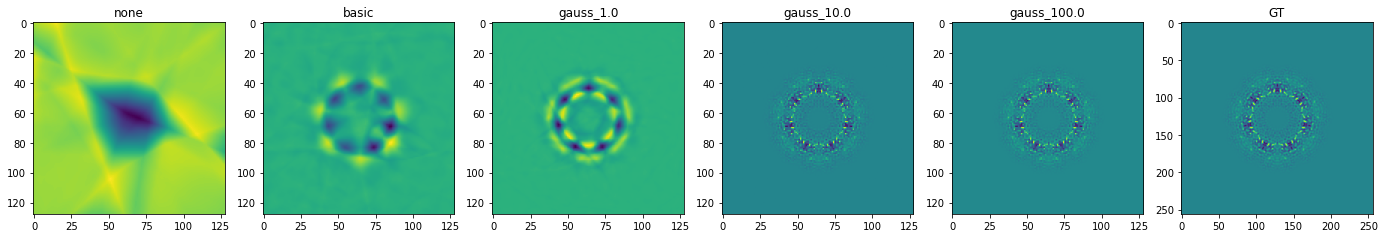

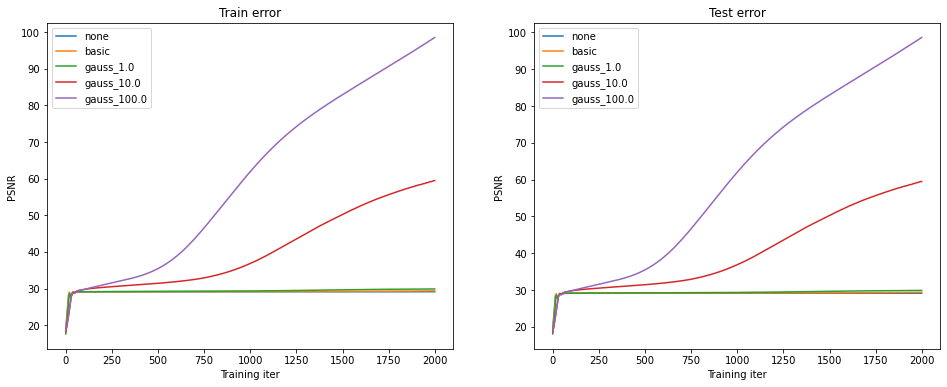

In [127]:
# Show final network outputs

plt.figure(figsize=(24,4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1,N+1,i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1].cpu().detach().numpy())
    plt.title(k)
plt.subplot(1,N+1,N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16,6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [45]:
'''
import os, imageio
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
print(img.shape)
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
print(img.shape)
'''

(689, 1024, 3)
(512, 512, 3)


(128, 128)


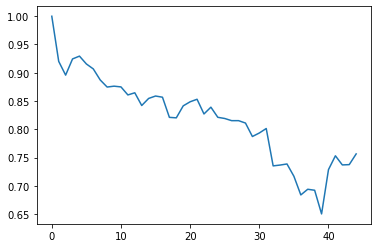

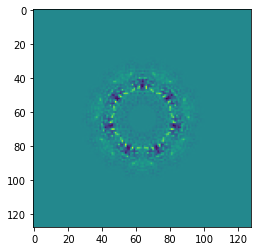

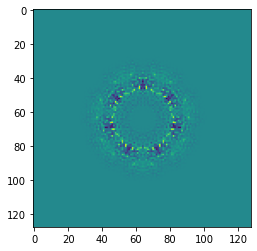

In [12]:
# Fourier ring coefficient test
    # https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html
    


def compute_frc(
        image_1: np.ndarray,
        image_2: np.ndarray,
        bin_width: int = 2.0
):
    """ Computes the Fourier Ring/Shell Correlation of two 2-D images

    :param image_1:
    :param image_2:
    :param bin_width:
    :return:
    """
    image_1 = image_1 / np.sum(image_1)
    image_2 = image_2 / np.sum(image_2)
    f1, f2 = np.fft.fft2(image_1), np.fft.fft2(image_2)
    af1f2 = np.real(f1 * np.conj(f2))
    af1_2, af2_2 = np.abs(f1)**2, np.abs(f2)**2
    nx, ny = af1f2.shape
    x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
    y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
    distances = list()
    wf1f2 = list()
    wf1 = list()
    wf2 = list()
    for xi, yi in np.array(np.meshgrid(x,y)).T.reshape(-1, 2):
        distances.append(np.sqrt(xi**2 + xi**2))
        xi = int(xi)
        yi = int(yi)
        wf1f2.append(af1f2[xi, yi])
        wf1.append(af1_2[xi, yi])
        wf2.append(af2_2[xi, yi])

    bins = np.arange(0, np.sqrt((nx//2)**2 + (ny//2)**2), bin_width)
    f1f2_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf1f2
    )
    f12_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf1
    )
    f22_r, bin_edges = np.histogram(
        distances,
        bins=bins,
        weights=wf2
    )
    density = f1f2_r / np.sqrt(f12_r * f22_r)
    return density, bin_edges

# Already got results for following, need to uncomment the first two and get those results

pred_image = outputs['gauss_100.0']['pred_imgs'][-1].cpu().detach().numpy().squeeze()
original_image = resize(img.squeeze(), pred_image.shape) # Hacky solution
# original_image = img.squeeze()
# pred_image = resize(outputs['gauss_100.0']['pred_imgs'][-1].cpu().detach().numpy().squeeze(), original_image.shape)

print(original_image.shape)

frc, frc_bins = compute_frc(original_image, pred_image)
plt.plot(frc, label="Intensity")
plt.show()

plt.imshow(original_image)
plt.show()
plt.imshow(pred_image)
plt.show()